# Rotated Object Detection

In this tutorial, you will learn:
- the basic structure of Rotate-RTMDet
- to perform inference with a MMRotate detector.
- to perform inference on huge image.

Let's start!


## Install MMRotate

In [1]:
import mmcv
import mmrotate
import mmdet
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
# Check mmcv installation
print(mmcv.__version__) #noqa E1101
# Check MMRotate installation
print(mmrotate.__version__)
# Check MMDetection installation
print(mmdet.__version__)

print(get_compiling_cuda_version())
print(get_compiler_version())

2.1.0
1.0.0rc1
3.2.0
12.1
GCC 9.3


## Perform Inference with An MMRotate detector



### A one-stage detector
In this tutorial, we use RTMDet, a fast and high precision one-stage detector as an example.
The high-level architecture of RTMDet is shown in the following picture. More details can be found in the paper.[paper](https://arxiv.org/abs/2212.07784)

The Network arch figure is as below:
![RTMDet](https://user-images.githubusercontent.com/27466624/204126145-cb4ff4f1-fb16-455e-96b5-17620081023a.jpg)

Briefly, it uses a big kernal convolutional neural network (CNN) as backbone to extract features from an image. Then, it uses a PAFPN neck to hierarchically extract feature, After that, if using in angle task, it uses 3 decouple head to predict classes, pred bbox and angle.

In [2]:
# We use mim to download the pre-trained checkpoints for inference and finetuning.
!mim download mmrotate --config rotated_rtmdet_l-3x-dota --dest .

processing rotated_rtmdet_l-3x-dota...
rotated_rtmdet_l-3x-dota-23992372.pth exists in /home/nikhil/Desktop/mmrotate_dota_2/demo
Successfully dumped rotated_rtmdet_l-3x-dota.py to /home/nikhil/Desktop/mmrotate_dota_2/demo


In [3]:
from mmengine.config import Config
from mmengine.runner import Runner

from mmdet.utils import register_all_modules as register_all_modules_mmdet
from mmdet.apis import inference_detector, init_detector

from mmrotate.registry import VISUALIZERS
from mmrotate.utils import register_all_modules

# register all modules in mmdet into the registries
# do not init the default scope here because it will be init in the runner
register_all_modules_mmdet(init_default_scope=False)
register_all_modules(init_default_scope=False)

# Choose to use a config and initialize the detector
config = 'rotated_rtmdet_l-3x-dota.py'
# Setup a checkpoint file to load
checkpoint = 'rotated_rtmdet_l-3x-dota-23992372.pth'
# Set work_dir
work_dir = '../work_dirs/rotated_rtmdet_l-3x-dota'
# Set the device to be used for evaluation
device='cuda:0'
# Set inference path
img = './demo.jpg'

cfg = Config.fromfile(config)
cfg.load_from = checkpoint
cfg.work_dir = work_dir

# register all modules in mmrotate into the registries
register_all_modules()

# build the model from a config file and a checkpoint file
model = init_detector(cfg, checkpoint, palette="dota", device=device)
model

Loads checkpoint by local backend from path: rotated_rtmdet_l-3x-dota-23992372.pth


RTMDet(
  (data_preprocessor): DetDataPreprocessor()
  (backbone): CSPNeXt(
    (stem): Sequential(
      (0): ConvModule(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): _BatchNormXd(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activate): SiLU(inplace=True)
      )
      (1): ConvModule(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): _BatchNormXd(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activate): SiLU(inplace=True)
      )
      (2): ConvModule(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): _BatchNormXd(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activate): SiLU(inplace=True)
      )
    )
    (stage1): Sequential(
      (0): ConvModule(
        (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), pa

From the printed model, we will find that the model does consist of the components that we described earlier. 

### Inference the detector

Since the model is successfully created and loaded, let's see how good it is. We use the high-level API `inference_detector` implemented in the MMDetection. This API is created to ease the inference process. The details of the codes can be found [here](https://github.com/open-mmlab/mmdetection/blob/master/mmdet/apis/inference.py#L15).

/home/nikhil/miniconda3/envs/exp/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1702400400184/work/aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/nikhil/miniconda3/envs/exp/lib/python3.8/site-packages/mmengine/visualization/visualizer.py:196: UserWarning: Failed to add <class 'mmengine.visualization.vis_backend.LocalVisBackend'>, please provide the `save_dir` argument.
  warnings.warn(f'Failed to add {vis_backend.__class__}, '
/home/nikhil/miniconda3/envs/exp/lib/python3.8/site-packages/mmengine/visualization/visualizer.py:831: UserWarning: Warning: The polygon is out of bounds, the drawn polygon may not be in the image
  warnings.warn(


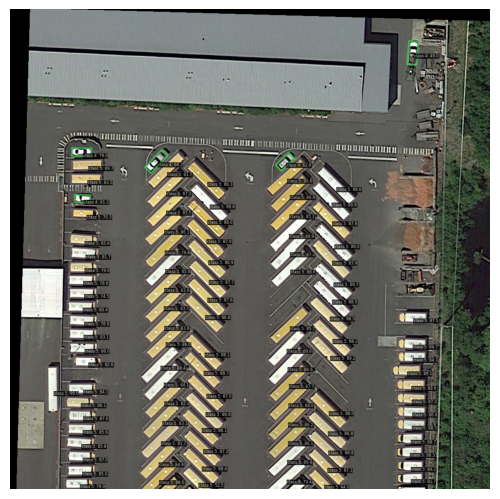

In [4]:
img = './demo.jpg'
img = mmcv.imread(img)
img = mmcv.imconvert(img, 'bgr', 'rgb')
result = inference_detector(model, img)

visualizer = VISUALIZERS.build(model.cfg.visualizer)
# show the results

visualizer.add_datasample(
    'result',
    img,
    data_sample=result,
    draw_gt=False,
    show=True,
    wait_time=0,
    pred_score_thr=0.3)
visualizer.show()

### Inference on huge image
Since small image can be successfully detected, what about huge images in remote sensing? We use the high-level API `inference_detector_by_patches` implemented in the MMRotate. This API is created to ease the inference process for huge image. The details of the codes can be found [here](https://github.com/open-mmlab/mmrotate/blob/dev/mmrotate/apis/inference.py).

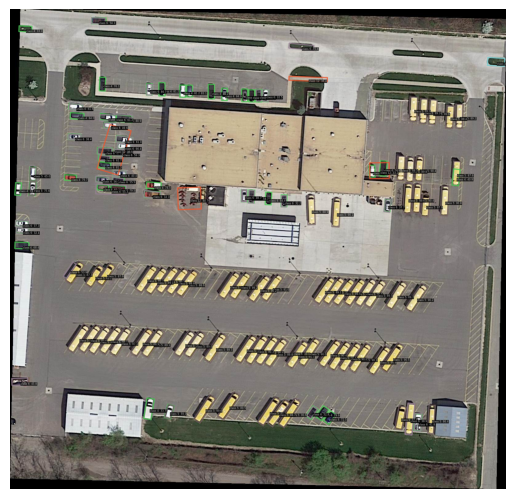

In [5]:
from mmrotate.apis import inference_detector_by_patches
img = './dota_demo.jpg'
nms_cfg = dict(type='nms_rotated', iou_threshold=0.1)
result = inference_detector_by_patches(model, img, [512], [500], [0.5,1.0,2.0], nms_cfg)

# show the results
img = mmcv.imread(img)
img = mmcv.imconvert(img, 'bgr', 'rgb')
visualizer.add_datasample(
    'result',
    img,
    data_sample=result,
    draw_gt=False,
    show=True,
    wait_time=0,
    pred_score_thr=0.3)
visualizer.show()

## Use TorchInfo to summary Rotate-RTMDet-l model info
To see the input output shape of each layer in Rotate-RTMDet-l model

In [6]:
%pip install torchinfo

  Using cached torchinfo-1.8.0-py3-none-any.whl.metadata (21 kB)
Using cached torchinfo-1.8.0-py3-none-any.whl (23 kB)
Note: you may need to restart the kernel to use updated packages.


In [7]:
from mmrotate.registry import MODELS
from mmrotate.testing import get_detector_cfg
from torchinfo import summary

cfg_file='../configs/rotated_rtmdet/rotated_rtmdet_l-3x-dota.py'
input_size=(1,3,1024,1024)
model=get_detector_cfg(cfg_file)
detector=MODELS.build(model)
summary(detector, input_size)

Layer (type:depth-idx)                                            Output Shape              Param #
RTMDet                                                            [1, 15, 128, 128]         --
├─CSPNeXt: 1-1                                                    [1, 256, 128, 128]        --
│    └─Sequential: 2-1                                            [1, 64, 512, 512]         --
│    │    └─ConvModule: 3-1                                       [1, 32, 512, 512]         928
│    │    └─ConvModule: 3-2                                       [1, 32, 512, 512]         9,280
│    │    └─ConvModule: 3-3                                       [1, 64, 512, 512]         18,560
│    └─Sequential: 2-2                                            [1, 128, 256, 256]        --
│    │    └─ConvModule: 3-4                                       [1, 128, 256, 256]        73,984
│    │    └─CSPLayer: 3-5                                         [1, 128, 256, 256]        178,624
│    └─Sequential: 2-3      

## Train a detector on customized dataset

To train a new detector, there are usually three things to do:
1. Support a new dataset
2. Modify the config
3. Train a new detector



### Support a new dataset

There are three ways to support a new dataset in MMRotate: 
  1. reorganize the dataset into DOTA format.
  2. reorganize the dataset into a middle format.
  3. implement a new dataset.

Usually we recommend to use the first two methods which are usually easier than the third.

In this tutorial, we gives an example that converting the data into the format of existing datasets like DOTA, etc. Other methods and more advanced usages can be found in the [doc](https://mmrotate.readthedocs.io/en/latest/tutorials/customize_dataset.html).

Firstly, let's download a SAR ship dataset obtained from [SSDD](https://github.com/TianwenZhang0825/Official-SSDD). We select the first 193 offshore images and their annotations from the dataset.

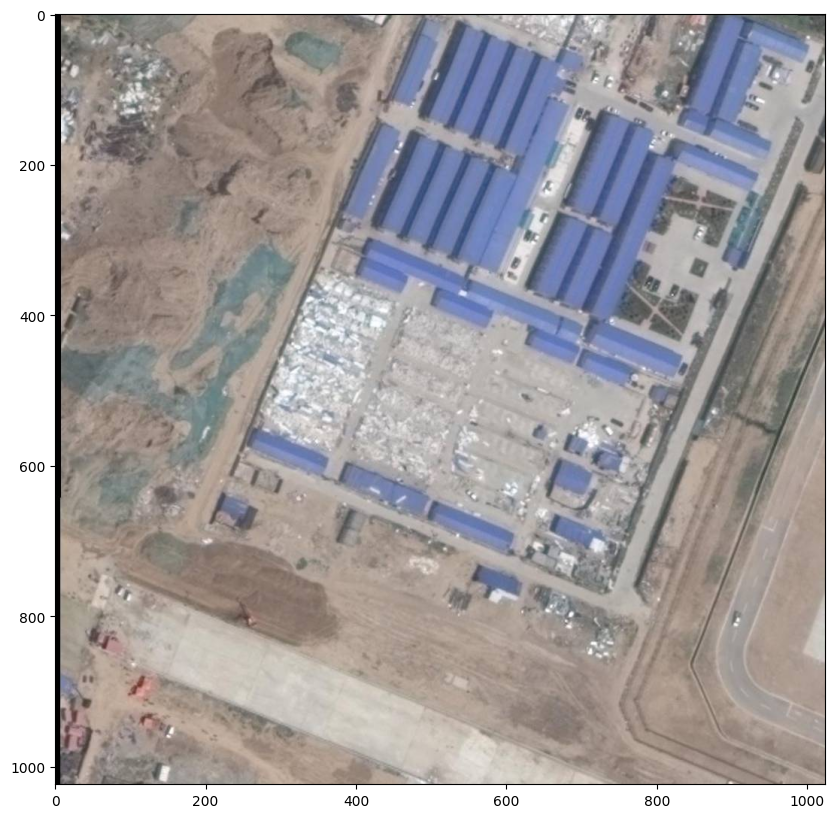

In [8]:
# Let's take a look at the dataset image
import matplotlib.pyplot as plt
img = mmcv.imread('split_ss_dota/train/images/P0000__1024__0___0.png')
plt.figure(figsize=(15, 10))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

Let's take a look at the annotation txt file.



In [9]:
# Check the label of a single image
!cat split_ss_dota/train/annfiles/P0000__1024__0___0.txt

717.0 76.0 726.0 78.0 722.0 95.0 714.0 90.0 small-vehicle 0
737.0 82.0 744.0 84.0 739.0 101.0 731.0 98.0 small-vehicle 0
658.0 242.0 648.0 237.0 657.0 222.0 667.0 225.0 small-vehicle 1
733.0 128.0 735.0 122.0 754.0 129.0 750.0 136.0 small-vehicle 0
770.0 144.0 773.0 137.0 788.0 144.0 784.0 151.0 small-vehicle 0
806.0 160.0 809.0 153.0 827.0 161.0 823.0 168.0 small-vehicle 0
696.0 122.0 705.0 124.0 697.0 141.0 691.0 137.0 small-vehicle 0
707.0 126.0 714.0 130.0 706.0 145.0 700.0 141.0 small-vehicle 0
711.0 140.0 718.0 141.0 712.0 157.0 706.0 154.0 small-vehicle 1
917.0 124.0 920.0 117.0 938.0 124.0 933.0 131.0 small-vehicle 0
924.0 113.0 926.0 106.0 945.0 115.0 942.0 122.0 small-vehicle 0
935.0 95.0 939.0 88.0 955.0 97.0 950.0 104.0 small-vehicle 1
856.0 282.0 864.0 286.0 856.0 303.0 849.0 298.0 small-vehicle 0
791.0 349.0 796.0 351.0 789.0 367.0 785.0 363.0 small-vehicle 0
799.0 354.0 805.0 357.0 799.0 370.0 793.0 368.0 small-vehicle 1
823.0 361.0 830.0 364.0 823.0 376.0 817.0 372.0 sm

In [10]:
from mmrotate.registry import DATASETS
from mmrotate.datasets.dota import DOTADataset

@DATASETS.register_module()
class TinyDataset(DOTADataset):
    """DOTA 2.0 dataset for detection."""
    
    METAINFO = {
            'classes':('storage-tank', 'large-vehicle', 'small-vehicle', 'roundabout', 'container-crane',),
                # palette is a list of color tuples, which is used for visualization.
            'palette': [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (128, 0, 128),]
        }

### Modify the config

In the next step, we need to modify the config for the training.
To accelerate the process, we finetune a detector using a pre-trained detector.

In [11]:
cfg = Config.fromfile('../configs/rotated_rtmdet/rotated_rtmdet_l-3x-dota.py')

Given a config that trains a Rotate-RTMDet-tiny on DOTA dataset, we need to modify some values to use it for training Rotate-RTMDet-tiny on SSDD dataset.

In [14]:
import random
import numpy as np
import torch


# Modify dataset type and path
cfg.data_root = 'split_ss_dota/'
cfg.dataset_type = 'TinyDataset'

# modify num classes of the model in box head
cfg.model.bbox_head.num_classes = 5
# We can still use the pre-trained Mask RCNN model though we do not need to
# use the mask branch
cfg.load_from = 'rotated_rtmdet_l-3x-dota-23992372.pth'

# Set up working dir to save files and logs.
cfg.work_dir = '../work_dirs/tutorial_exps'

cfg.optim_wrapper.optimizer.lr = 0.001

cfg.train_cfg.val_interval = 3
# Change the evaluation metric since we use customized dataset.
cfg.val_evaluator.metric = 'mAP'
# We can set the evaluation interval to reduce the evaluation times
cfg.val_evaluator.interval = 3
# We can set the checkpoint saving interval to reduce the storage cost
cfg.default_hooks.checkpoint.interval = 1
cfg.max_epochs=3
cfg.train_cfg.max_epochs=cfg.max_epochs

# Set seed thus the results are more reproducible
cfg.seed = 0
random.seed(cfg.seed)
np.random.seed(cfg.seed)
torch.cuda.manual_seed(cfg.seed)
torch.cuda.manual_seed_all(cfg.seed)

cfg.gpu_ids = range(1)
cfg.device='cuda'


# modify pipeline mainly for resize scale (512,512)
cfg.train_pipeline = [
    dict(type='mmdet.LoadImageFromFile', backend_args=None),
    dict(type='mmdet.LoadAnnotations', with_bbox=True, box_type='qbox'),
    dict(type='ConvertBoxType', box_type_mapping=dict(gt_bboxes='rbox')),
    dict(type='mmdet.Resize', scale=(1024, 1024), keep_ratio=True),
    dict(
        type='mmdet.RandomFlip',
        prob=0.75,
        direction=['horizontal', 'vertical', 'diagonal']),
    dict(
        type='RandomRotate',
        prob=0.5,
        angle_range=180,
        rect_obj_labels=[9, 11]),
    dict(
        type='mmdet.Pad', size=(1024, 1024),
        pad_val=dict(img=(114, 114, 114))),
    dict(type='mmdet.PackDetInputs')
]
cfg.val_pipeline = [
    dict(type='mmdet.LoadImageFromFile', backend_args=None),
    dict(type='mmdet.Resize', scale=(1024, 1024), keep_ratio=True),
    dict(type='mmdet.LoadAnnotations', with_bbox=True, box_type='qbox'),
    dict(type='ConvertBoxType', box_type_mapping=dict(gt_bboxes='rbox')),
    dict(
        type='mmdet.Pad', size=(1024, 1024),
        pad_val=dict(img=(114, 114, 114))),
    dict(
        type='mmdet.PackDetInputs',
        meta_keys=('img_id', 'img_path', 'ori_shape', 'img_shape',
                   'scale_factor'))
]
cfg.test_pipeline = [
    dict(type='mmdet.LoadImageFromFile', backend_args=None),
    dict(type='mmdet.Resize', scale=(1024, 1024), keep_ratio=True),
    dict(
        type='mmdet.Pad', size=(1024, 1024),
        pad_val=dict(img=(114, 114, 114))),
    dict(
        type='mmdet.PackDetInputs',
        meta_keys=('img_id', 'img_path', 'ori_shape', 'img_shape',
                   'scale_factor'))
]


cfg.val_dataloader.dataset.type = cfg.dataset_type
cfg.val_dataloader.dataset.ann_file = 'annfiles'
cfg.val_dataloader.dataset.data_prefix=dict(img_path='images', img='images')
# cfg.val_dataloader.dataset.img_prefix = 'images'
cfg.val_dataloader.dataset.data_root = 'split_ss_dota/val'

cfg.train_dataloader.dataset.type = cfg.dataset_type
cfg.train_dataloader.dataset.ann_file = 'annfiles'
cfg.train_dataloader.dataset.data_prefix=dict(img_path='images', img='images')
# cfg.train_dataloader.dataset.img_prefix = 'images'
cfg.train_dataloader.dataset.data_root = 'split_ss_dota/train'
cfg.train_dataloader.batch_size = 2

cfg.test_dataloader.dataset.type = cfg.dataset_type
cfg.test_dataloader.dataset.data_prefix=dict(img_path='images', img='images')
cfg.test_dataloader.dataset.ann_file = 'annfiles'
# cfg.test_dataloader.dataset.img_prefix = 'images'
cfg.test_dataloader.dataset.data_root = 'split_ss_dota/val'

cfg.train_dataloader.dataset.pipeline=cfg.train_pipeline
cfg.val_dataloader.dataset.pipeline=cfg.val_pipeline
cfg.test_dataloader.dataset.pipeline=cfg.test_pipeline

cfg.val_evaluator = dict(type='DOTAMetric', metric='mAP')
cfg.test_evaluator = cfg.val_evaluator
# We can also use tensorboard to log the training process
cfg.vis_backends=[dict(type='TensorboardVisBackend')]
cfg.visualizer = dict(type='mmrotate.RotLocalVisualizer',vis_backends=cfg.vis_backends)

# We can initialize the logger for training and have a look
# at the final config used for training
cfg.dump('./tiny_cfg.py')
print(f'Config:\n{cfg.pretty_text}')

Config:
angle_version = 'le90'
backend_args = None
base_lr = 0.00025
checkpoint = 'https://download.openmmlab.com/mmdetection/v3.0/rtmdet/cspnext_rsb_pretrain/cspnext-l_8xb256-rsb-a1-600e_in1k-6a760974.pth'
custom_hooks = [
    dict(type='mmdet.NumClassCheckHook'),
    dict(
        ema_type='mmdet.ExpMomentumEMA',
        momentum=0.0002,
        priority=49,
        type='EMAHook',
        update_buffers=True),
]
data_root = 'split_ss_dota/'
dataset_type = 'TinyDataset'
default_hooks = dict(
    checkpoint=dict(interval=1, max_keep_ckpts=3, type='CheckpointHook'),
    logger=dict(interval=50, type='LoggerHook'),
    param_scheduler=dict(type='ParamSchedulerHook'),
    sampler_seed=dict(type='DistSamplerSeedHook'),
    timer=dict(type='IterTimerHook'),
    visualization=dict(type='mmdet.DetVisualizationHook'))
default_scope = 'mmrotate'
device = 'cuda'
env_cfg = dict(
    cudnn_benchmark=False,
    dist_cfg=dict(backend='nccl'),
    mp_cfg=dict(mp_start_method='fork', opencv_num_threa

### Train a new detector

Finally, lets initialize the dataset and detector, then train a new detector!

In [15]:
# register all modules in mmdet into the registries
# do not init the default scope here because it will be init in the runner
register_all_modules_mmdet(init_default_scope=False)
register_all_modules(init_default_scope=False)

# register all modules in mmrotate into the registries
register_all_modules()

# build the model from a config file and a checkpoint file
model = init_detector(cfg, cfg.checkpoint, palette="dota", device=cfg.device)


runner = Runner.from_cfg(cfg)
runner.train()

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmdetection/v3.0/rtmdet/cspnext_rsb_pretrain/cspnext-l_8xb256-rsb-a1-600e_in1k-6a760974.pth
The model and loaded state dict do not match exactly

unexpected key in source state_dict: head.fc.weight, head.fc.bias

missing keys in source state_dict: neck.reduce_layers.0.conv.weight, neck.reduce_layers.0.bn.weight, neck.reduce_layers.0.bn.bias, neck.reduce_layers.0.bn.running_mean, neck.reduce_layers.0.bn.running_var, neck.reduce_layers.1.conv.weight, neck.reduce_layers.1.bn.weight, neck.reduce_layers.1.bn.bias, neck.reduce_layers.1.bn.running_mean, neck.reduce_layers.1.bn.running_var, neck.top_down_blocks.0.main_conv.conv.weight, neck.top_down_blocks.0.main_conv.bn.weight, neck.top_down_blocks.0.main_conv.bn.bias, neck.top_down_blocks.0.main_conv.bn.running_mean, neck.top_down_blocks.0.main_conv.bn.running_var, neck.top_down_blocks.0.short_conv.conv.weight, neck.top_down_blocks.0.short_conv.bn.weight, neck.top_dow

/home/nikhil/Desktop/mmrotate_dota_2/mmrotate/structures/bbox/rotated_boxes.py:192: UserWarning: The `clip` function does nothing in `RotatedBoxes`.
  warnings.warn('The `clip` function does nothing in `RotatedBoxes`.')
/home/nikhil/Desktop/mmrotate_dota_2/mmrotate/structures/bbox/rotated_boxes.py:192: UserWarning: The `clip` function does nothing in `RotatedBoxes`.
  warnings.warn('The `clip` function does nothing in `RotatedBoxes`.')
/home/nikhil/Desktop/mmrotate_dota_2/mmrotate/structures/bbox/rotated_boxes.py:192: UserWarning: The `clip` function does nothing in `RotatedBoxes`.
  warnings.warn('The `clip` function does nothing in `RotatedBoxes`.')
/home/nikhil/Desktop/mmrotate_dota_2/mmrotate/structures/bbox/rotated_boxes.py:192: UserWarning: The `clip` function does nothing in `RotatedBoxes`.
  warnings.warn('The `clip` function does nothing in `RotatedBoxes`.')


12/15 16:57:30 - mmengine - INFO - Epoch(train) [1][  50/3194]  base_lr: 4.9059e-05 lr: 4.9059e-05  eta: 1:20:47  time: 0.5085  data_time: 0.0085  memory: 9428  loss: 2.8704  loss_cls: 2.2672  loss_bbox: 0.6032
12/15 16:57:55 - mmengine - INFO - Epoch(train) [1][ 100/3194]  base_lr: 9.9108e-05 lr: 9.9108e-05  eta: 1:19:40  time: 0.4999  data_time: 0.0047  memory: 9315  loss: 2.6427  loss_cls: 2.0778  loss_bbox: 0.5649
12/15 16:58:21 - mmengine - INFO - Epoch(train) [1][ 150/3194]  base_lr: 1.4916e-04 lr: 1.4916e-04  eta: 1:19:25  time: 0.5075  data_time: 0.0046  memory: 9732  loss: 1.8024  loss_cls: 1.2547  loss_bbox: 0.5477
12/15 16:58:46 - mmengine - INFO - Epoch(train) [1][ 200/3194]  base_lr: 1.9921e-04 lr: 1.9921e-04  eta: 1:18:54  time: 0.5027  data_time: 0.0046  memory: 9282  loss: 1.1448  loss_cls: 0.6427  loss_bbox: 0.5021
12/15 16:59:11 - mmengine - INFO - Epoch(train) [1][ 250/3194]  base_lr: 2.4926e-04 lr: 2.4926e-04  eta: 1:18:32  time: 0.5065  data_time: 0.0047  memory: 9

RTMDet(
  (data_preprocessor): DetDataPreprocessor()
  (backbone): CSPNeXt(
    (stem): Sequential(
      (0): ConvModule(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): _BatchNormXd(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activate): SiLU(inplace=True)
      )
      (1): ConvModule(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): _BatchNormXd(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activate): SiLU(inplace=True)
      )
      (2): ConvModule(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): _BatchNormXd(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activate): SiLU(inplace=True)
      )
    )
    (stage1): Sequential(
      (0): ConvModule(
        (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), pa

## Test the trained detector

After finetuning the detector, let's visualize the prediction results!

Loads checkpoint by local backend from path: ../work_dirs/tutorial_exps/epoch_3.pth


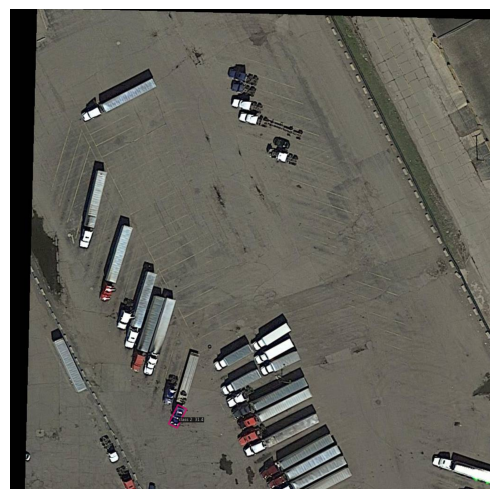

In [17]:
img = mmcv.imread('split_ss_dota/test/images/P0009__1024__0___0.png')
checkpoint="../work_dirs/tutorial_exps/epoch_3.pth"
device='cuda:0'
cfg=Config.fromfile('./tiny_cfg.py')
model = init_detector(cfg, checkpoint, palette="dota", device=device)
result = inference_detector(model, img)
# show the results
img = mmcv.imread(img)
img = mmcv.imconvert(img, 'bgr', 'rgb')
visualizer.add_datasample(
    'result',
    img,
    data_sample=result,
    draw_gt=False,
    show=True,
    wait_time=0,
    pred_score_thr=0.3)
visualizer.show()